# Sim III: Contact dynamics

In [5]:
from utils import magic_donotload

In [6]:
import numpy as np
import pinocchio as pin

from utils.contact_dyn import create_cubes, computeContactProblem
from utils.visualization import sub_sample

## Implementation of Projected Gauss Seidel

You should implement a contact solver using PGS with the following API:

In [7]:
def solve_contact(G: np.ndarray,g: np.ndarray, mus: list, tol : float = 1e-6, max_iter :int = 100) -> np.ndarray:
    """PGS algorithm solving a contact problem with frictions.

    Args:
        G (np.ndarray): Delassus matrix.
        g (np.ndarray): free velocity of contact points.
        mus (list): list of coefficients of friction for the contact points.
        tol (float, optional): solver tolerance. Defaults to 1e-6.
        max_iter (int, optional): maximum number of iterations for the solver. Defaults to 100.

    Returns:
        np.ndarray: contact impulses.
    """
    # TODO : PGS
    return 

In [8]:
%do_not_load -r 3-25 pgs.py

### Simulating a cube on a plane

We build the pinocchio model of a cube and a plane (which stands for the floor) and we fix th simulation parameters (time step, contact solver accuracy etc)

In [9]:
np.random.seed(1234)
pin.seed(12345)

## First example: a cube falling on the floor

cube_dimension = 0.2  # size of cube
cube_mass = 1.0  # mass of cube
mu = 0.95  # friction parameter
eps = 0.0  # elasticity
model, geom_model, visual_model, data, geom_data, visual_data, actuation = create_cubes(
    [cube_dimension], [cube_mass], mu, eps
) # creating pinocchio models and datas


duration = 1. # duration of simulation
dt = 1e-3 # time step duration
T = int(duration/dt) # number of time steps

tolerance = 1e-6 #contact solver accuracy
max_iter = 100 #maximum number of iterations of the contact solver

In [10]:
from tqdm import trange
# initial state
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)
q0[2] = cube_dimension
rand_place = pin.SE3.Random()
q0[-4:] = pin.SE3ToXYZQUAT(rand_place)[-4:]

q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0] #arrays to store trajectory

for t in trange(T): # simulation loop 
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del,g, mus = computeContactProblem(model, data, geom_model, geom_data, q, v, tau, dt)
    if J is not None:
        lam = solve_contact(Del, g, mus, tolerance, max_iter)
        dv = dt*pin.aba(model, data, q, v, tau + J.T @ lam/dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model , q, v*dt)
    qs += [q]
    vs += [v]

  8%|▊         | 76/1000 [00:00<00:00, 14715.50it/s]

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

### Visualizing

In [15]:
from pinocchio.visualize import MeshcatVisualizer
import meshcat
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=True, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2] #camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)]*numrep

max_fps = 30.
fps = min([max_fps,1./dt])
qs = sub_sample(qs,dt*T, fps)
vs = sub_sample(vs,dt*T, fps)

def get_callback(i: int):
    def _callback(t):
        vizer.setCameraPosition(cps_[i])
        vizer.setCameraTarget(rps_[i])
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])
    return _callback


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [ ]:
vizer.viewer.jupyter_cell()

In [ ]:
for i in range(numrep):
    vizer.play(
        qs,
        1./fps,
        get_callback(i)
    )

## Impact of over-relax on convergence speed

In [22]:
def solve_contact_over_relax(G: np.ndarray,g: np.ndarray, mus: list, dt: float, tol : float = 1e-6, max_iter :int = 100, alpha_or : float = 1.) -> (np.ndarray, np.ndarray):
    """PGS algorithm solving a contact problem with frictions.

    Args:
        G (np.ndarray): Delassus matrix.
        g (np.ndarray): free velocity of contact points.
        mus (list): list of coefficients of friction for the contact points.
        dt (float): time step.
        tol (float, optional): solver tolerance. Defaults to 1e-6.
        max_iter (int, optional): maximum number of iterations for the solver. Defaults to 100.
        alpha_or (float, optional): over-relaxation parameter. Defaults to 1.

    Returns:
        np.ndarray: contact impulses.
        np.ndarray: value of Signorini complementarity accross iterations of the algorithm.
    """
    # TODO : PGS
    nc = len(mus)
    lam = np.zeros(3*nc)
    v = np.zeros(3*nc)
    sig_comps = np.zeros(max_iter)
    for j in range(max_iter):
        for i in range(nc):
            lam[3*i+2] = lam[3*i+2] - (alpha_or/G[3*i+2, 3*i+2])*(G[3*i+2] @ lam + g[3*i+2])
            lam[3*i+2] = np.max([0., lam[3*i+2]])
            lam[3*i:3*i+2] = lam[3*i:3*i+2] - (alpha_or/np.min([G[3*i, 3*i], G[3*i+1, 3*i+1]]))*(G[3*i:3*i+2] @ lam + g[3*i:3*i+2])
            lam[3*i:3*i+2] = np.clip(lam[3*i:3*i+2], -mus[i]*lam[3*i+2], mus[i]*lam[3*i+2])
            v= G @ lam + g
            sig_compi = np.abs(v[3*i+2]*lam[3*i+2]/dt)
            if sig_compi  > sig_comps[j]:
                sig_comps[j] = sig_compi
    return lam, sig_comps

In [23]:
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)
q, v = q0.copy(), v0.copy()
tau = np.zeros(model.nv)
pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
pin.computeCollisions(geom_model, geom_data, False)
J, vf, Del,g, mus = computeContactProblem(model, data, geom_model, geom_data, q, v, tau, dt)

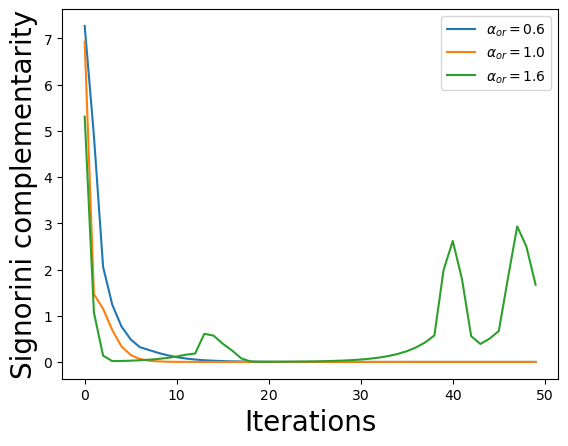

In [25]:
import matplotlib.pyplot as plt
max_iter = 50
iterations = [i for i in range(max_iter)]
alpha_ors = [.6,1.,1.6]
plt.figure()
for alpha_or in alpha_ors:
    lam, sig_comps = solve_contact_over_relax(Del, g, mus, dt, tolerance, max_iter, alpha_or=alpha_or)
    plt.plot(iterations, sig_comps, label = r"$\alpha_{or}=$"+str(alpha_or))
plt.legend()
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Signorini complementarity", fontsize=20)
plt.show()

## Instability of PGS

### Simulating two stacked cubes

In [39]:
cube_dimension = 0.2  # size of cube
cube1_mass = 1e-3  # mass of cube 1
cube2_mass = 1e3  # mass of cube 2
mu = 0.9  # friction parameter between cube and floor
el = 0.
comp = 0.
model, geom_model, visual_model, data, geom_data, visual_data, actuation = create_cubes(
    [cube_dimension, cube_dimension], [cube1_mass, cube2_mass], mu, el
)

# Number of time steps
T = 100
dt = 1e-3

# Physical parameters of the contact problem
Kb = 1e-4*0.  # Baumgarte
eps = 0.0  # elasticity

In [40]:
# initial state
q0 = pin.neutral(model)
q0[2] = cube_dimension / 2 + cube_dimension/50.
q0[9] = 3. * cube_dimension / 2 + 3*cube_dimension/50.
v0 = np.zeros(model.nv)
q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0] #arrays to store trajectory

for t in trange(T): # simulation loop 
    tau = np.zeros(model.nv)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del,g, mus = computeContactProblem(model, data, geom_model, geom_data, q, v, tau, dt)
    if J is not None:
        lam, _ = solve_contact_over_relax(Del, g, mus, dt, tolerance, max_iter)
        dv = dt*pin.aba(model, data, q, v, tau + J.T @ lam/dt)
        v += dv
    else:
        v = vf
    q = pin.integrate(model , q, v*dt)
    qs += [q]
    vs += [v]

100%|██████████| 100/100 [00:01<00:00, 94.27it/s]


### Visualization

In [41]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=True, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [0.8, 0.0, 0.2] #camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)]*numrep

max_fps = 30.
fps = min([max_fps,1./dt])
qs = sub_sample(qs,dt*T, fps)
vs = sub_sample(vs,dt*T, fps)

def get_callback(i: int):
    def _callback(t):
        vizer.setCameraPosition(cps_[i])
        vizer.setCameraTarget(rps_[i])
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])
    return _callback

for i in range(numrep):
    vizer.play(
        qs,
        1./fps,
        get_callback(i)
    )

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


### Inspecting convergence

In [42]:
# initial state
q0 = pin.neutral(model)
q0[2] = cube_dimension / 2 + cube_dimension/50.
q0[9] = 3. * cube_dimension / 2 + 3*cube_dimension/50.
v0 = np.zeros(model.nv)
q, v = q0.copy(), v0.copy()

tau = np.zeros(model.nv)
pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
pin.computeCollisions(geom_model, geom_data, False)
J, vf, Del,g, mus = computeContactProblem(model, data, geom_model, geom_data, q, v, tau, dt)
lam, sig_comps  = solve_contact_over_relax(Del, g, mus, dt, tolerance, max_iter)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


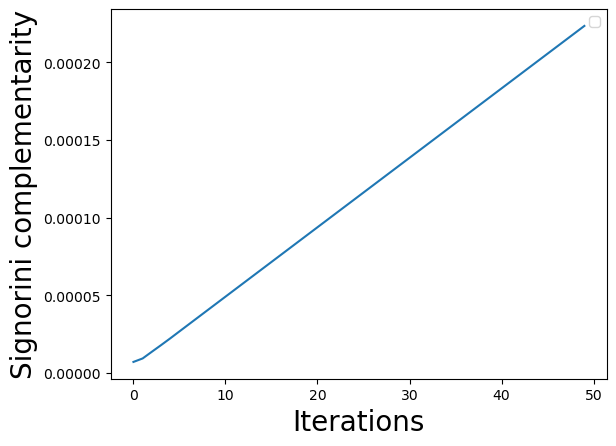

In [43]:
plt.figure()
iterations = [i for i in range(max_iter)]
plt.plot(iterations, sig_comps)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Signorini complementarity", fontsize=20)
plt.show()

## Internal forces

### Simulating a dragged cube

In [65]:
cube_dimension = 0.2  # size of cube
cube_mass = 1.0  # mass of cube
mu = 0.95  # friction parameter
eps = 0.0  # elasticity
model, geom_model, visual_model, data, geom_data, visual_data, actuation = create_cubes(
    [cube_dimension], [cube_mass], mu, eps
)

# duration of simulation
duration = .5
# time steps
dt = 1e-3
T = int(duration/dt)

# numerical precision
tolerance = 1e-6
max_iter = 100

In [66]:
q0 = model.qinit.copy()
v0 = np.zeros(model.nv)

q, v = q0.copy(), v0.copy()

qs, vs = [q0], [v0] #arrays to store trajectory

internal_forces = np.zeros((T,4)) # store contact force along x axis for each contact point at every time step

for t in trange(T): # simulation loop 
    tau = np.zeros(model.nv)
    tau[1] = t*.1 # applying an increasing force pushing the cube along y axis
    pin.updateGeometryPlacements(model, data, geom_model, geom_data, q)
    pin.computeCollisions(geom_model, geom_data, False)
    J, vf, Del,g, mus = computeContactProblem(model, data, geom_model, geom_data, q, v, tau, dt)
    if J is not None:
        lam = solve_contact(Del, g, mus, tolerance, max_iter)
        dv = dt*pin.aba(model, data, q, v, tau + J.T @ lam/dt)
        v += dv
        for i in range(4):
            internal_forces[t,i] = lam[3*i]/dt
    else:
        v = vf
    q = pin.integrate(model , q, v*dt)
    qs += [q]
    vs += [v]

100%|██████████| 500/500 [00:04<00:00, 103.58it/s]


In [67]:
vizer = MeshcatVisualizer(model, geom_model, visual_model)
vizer.initViewer(open=True, loadModel=True)

vizer.viewer["plane"].set_object(meshcat.geometry.Box(np.array([20, 20, 0.1])))
placement = np.eye(4)
placement[:3, 3] = np.array([0, 0, -0.05])
vizer.viewer["plane"].set_transform(placement)
vizer.display(q0)

cp1 = [1., 0.0, 0.2] #camera position
cps_ = [cp1]
numrep = len(cps_)
rps_ = [np.zeros(3)]*numrep

max_fps = 30.
fps = min([max_fps,1./dt])
q0[2] = cube_dimension
rand_place = pin.SE3.Random()
q0[-4:] = pin.SE3ToXYZQUAT(rand_place)[-4:]
qs = sub_sample(qs,dt*T, fps)
vs = sub_sample(vs,dt*T, fps)

def get_callback(i: int):
    def _callback(t):
        vizer.setCameraPosition(cps_[i])
        vizer.setCameraTarget(rps_[i])
        pin.forwardKinematics(model, vizer.data, qs[t], vs[t])
    return _callback

for i in range(numrep):
    vizer.play(
        qs,
        1./fps,
        get_callback(i)
    )

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


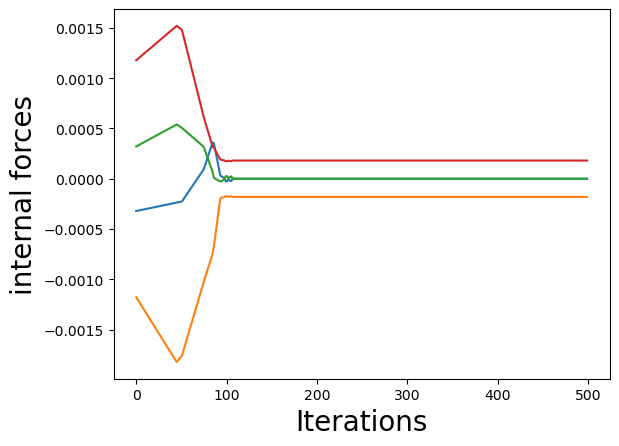

In [68]:
plt.figure()
timesteps = [t for t in range(T)]
plt.plot(timesteps, internal_forces)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Time-step", fontsize=20)
plt.show()